# Введение

Мы располагаем определенным набором данных о событиях, произошедших в мобильной игре «Космические братья». В ней пользователи строят свою космическую программу и пытаются преуспеть в нелёгком деле колонизации галактики.

Основная монетизация игры — только планируется. Но предполагается, что в приложении будет происходить показ рекламы на экране с выбором типа объекта для постройки.

В основном датасете представлены данные по игре пользователей на первом уровне. Завершение первого уровня требует от игрока выполнения одного из двух условий:

- Победа над первым врагом
- Реализация проекта - разработка орбитальной сборки спутников

В основном датасете содержатся данные первых пользователей приложения — когорты пользователей, которые начали пользоваться приложением в период с 4 по 10 мая включительно.

Также у нас есть два датасета с дополнителньой информацией


##  Загрузка данных и ознакомление с ними

Итак, приступим к работе. Для начала импортируем библиотеки, которыми мы будем пользоваться в ходе исследования:

In [1]:
import pandas as pd
import numpy as np 
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-dark')  # просто для красивости
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning) 
pd.options.mode.chained_assignment = None  

Теперь мы можем приступать к нашим данным. 

У нас есть три датасета, которыми мы будем пользоваться. Загружаем их все вместе.

In [2]:
game_actions = pd.read_csv('/datasets/game_actions.csv')
ad_costs = pd.read_csv('/datasets/ad_costs.csv')
user_source = pd.read_csv('/datasets/user_source.csv')

Согласно легенде исследования, таблицы имеют следующее наполнение:

Датасет *game_actions.csv*:

- `event_datetime` — время события;
- `event` — одно из трёх событий:
    1. `building` — объект построен,
    2. `finished_stage_1` — первый уровень завершён,
    3. `project` — проект завершён;
- `building_type` — один из трёх типов здания:
    1. `assembly_shop` — сборочный цех,
    2. `spaceport` — космопорт,
    3. `research_center` — исследовательский центр;
- `user_id` — идентификатор пользователя;
- `project_type` — тип реализованного проекта;

Датасет *ad_cost.csv* содержит колонки:

- `day` - день, в который был совершен клик по объявлению
- `source` - источник трафика
- `cost` - стоимость кликов

Датасет user_source.csv содержит колонки:

- `user_id` - идентификатор пользователя
- `source` - источников, с которого пришёл пользователь, установивший приложение

Для удобства напишем небольшую функцию для получения общей информации о каждой из таблиц:

In [3]:
def total_info (df):
    display(df.head(5))  # шапка
    print()
    df.info()  # общая информация
    print()
    print("Количество пропусков:")  # смотрим на пропуски
    print(df.isna().sum())
    print()
    print("Количество дубликатов: {}".format(df.duplicated().sum()))   #смотрим на дубликаты
    print()
    df=df.drop_duplicates()
    

И мы начинаем с первой таблицы, использую нашу функцию:

In [4]:
total_info(game_actions)

,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135640 non-null  object
 1   event           135640 non-null  object
 2   building_type   127957 non-null  object
 3   user_id         135640 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 5.2+ MB

Количество пропусков:
event_datetime         0
event                  0
building_type       7683
user_id                0
project_type      133774
dtype: int64

Количество дубликатов: 1



Есть большое количество пропусков в столбцах `building type`, `project_type`. Также имеется дубликат и потребуется сменить тип данных в столбце `event_datetime`. Не совсем понятно, какие значения содержатся в столбце `project_type`. Разберемся с этим на предобработке.

Вторая таблица:

In [5]:
total_info(ad_costs)

,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754
3,facebook_ads,2020-05-06,177.982200
4,facebook_ads,2020-05-07,111.766796



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes

Количество пропусков:
source    0
day       0
cost      0
dtype: int64

Количество дубликатов: 0



Ситуация с дубликатами получше, пропусков тоже не наблюдается. Потребуется сменить тип данных в столбце `date`.

И третья таблица:

In [6]:
total_info(user_source)

,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  13576 non-null  object
 1   source   13576 non-null  object
dtypes: object(2)
memory usage: 212.2+ KB

Количество пропусков:
user_id    0
source     0
dtype: int64

Количество дубликатов: 0



Пропусков и дубликатов нет, к типу данных вопросов тоже нет. Можно приступать к предобработке.

### Выводы

Мы ознакомились со всеми доступными таблицами и выявили круг задач для предобработки данных.

##  Предобработка данных

Приступаем к предобработке. Для начала освежим информацию о таблице `game_actions`:

In [7]:
game_actions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135640 non-null  object
 1   event           135640 non-null  object
 2   building_type   127957 non-null  object
 3   user_id         135640 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 5.2+ MB


Начнем со смены типа данных в столбце `event_datetime`:

In [8]:
game_actions['event_datetime'] = pd.to_datetime(game_actions['event_datetime'], format='%Y-%m-%d %H:%M:%S')

Выделим постройки в отдельный технический датафрейм:

In [9]:
#building_types = game_actions.query('event = "building"')
building_types = game_actions['building_type'].value_counts().reset_index()
display(building_types)

,index,building_type
0,spaceport,59325
1,assembly_shop,54494
2,research_center,14138


Мы видим, что у нас присутствует три типа построек, доступных игрокам на первом уровне.

Заполним пропуски в столбце `project_type` значением `unknown`, чтобы различать игроков, которые не построили орбитальную станцию.

In [10]:
game_actions['project_type'] = game_actions['project_type'].fillna('unknown')

Проверяем:

In [11]:
game_actions['project_type'].value_counts()

unknown                       133774
satellite_orbital_assembly      1866
Name: project_type, dtype: int64

Ага, а вот и ценная информация - мы знаем, что минимум 1866 пользователей перешли на второй уровень, завершив постройку спутниковой станции.

Теперь посмотрим, что за дубликат у нас был:

In [12]:
game_actions[game_actions.duplicated(keep=False)]

,event_datetime,event,building_type,user_id,project_type
74890,2020-05-10 18:41:56,building,research_center,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,unknown
74891,2020-05-10 18:41:56,building,research_center,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,unknown


Полное совпадение значений. Вероятно, запись занесена по ошибке. Можно удалять:

In [13]:
game_actions = game_actions.drop_duplicates()

Последняя проверка:

In [14]:
game_actions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135639 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   event_datetime  135639 non-null  datetime64[ns]
 1   event           135639 non-null  object        
 2   building_type   127956 non-null  object        
 3   user_id         135639 non-null  object        
 4   project_type    135639 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 6.2+ MB


Другое дело, тип данных поменяли, все пропуски заполнены.

Переходим к таблице `ad_costs`. Меняем тип данных и проверяем:

In [15]:
ad_costs['day'] = pd.to_datetime(ad_costs['day'], format='%Y-%m-%d')

In [16]:
ad_costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   source  28 non-null     object        
 1   day     28 non-null     datetime64[ns]
 2   cost    28 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 800.0+ bytes


Теперь все в порядке.

### Выводы

Мы провели необходимую предобработку: поменяли тип данных в двух столбцах, избавились от одного дубликата, а также заполнили пропуски заданными нами значениями

## Исследовательский анализ данных

Приступаем к исследовательскому анализу данных.

Для начала посмотрим, сколько же у нас всего пользователей в игре:

In [17]:
print(f'Количество уникальных пользователей {game_actions["user_id"].nunique()}.')

Количество уникальных пользователей 13576.


Почти 14 000 человек, немало.

Теперь посмотрим, в каком интервале происходят игровые события:

In [18]:
print(f'Минимальная дата события {game_actions["event_datetime"].min()}.')
print(f'Максимальная дата события {game_actions["event_datetime"].max()}.')

Минимальная дата события 2020-05-04 00:00:01.
Максимальная дата события 2020-06-05 12:32:49.


Мы видим, что у нас есть данные за месяц игры. Значит, игра не совсем плохая, если люди играют в нее столько времени.

Посмотрим на распределение внутриигровых событий:

,event_type,amount,%_of_total
0,building,127956,94.34
1,finished_stage_1,5817,4.29
2,project,1866,1.38


<function matplotlib.pyplot.show(close=None, block=None)>

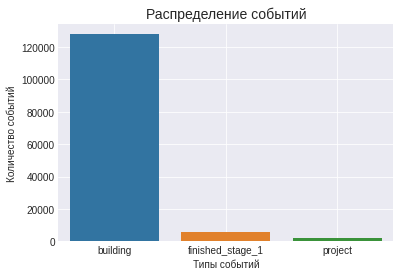

In [19]:
events = game_actions['event'].value_counts().reset_index()
events['%_of_total'] = round((events['event']/events['event'].sum()*100), 2)  # проценты для удобства
events = events.rename(columns = {'index':'event_type', 'event':'amount'})
display(events)



sns.countplot(game_actions['event'])
plt.grid()
plt.title('Распределение событий', fontsize = 14)
plt.xlabel('Типы событий')
plt.ylabel('Количество событий')
plt.show

У нас появились данные о пользователях, которые выполнили условие перехода на второй уровень - это событие типа `finished_stage_1`. Также мы видим, что 1866 пользователей перешли на второй уровень через завершение проекта (тип события `project`). Всего  на второй уровень перешли 5817 пользователей, что составляет:

In [20]:
second_levellers = events.query("event_type =='finished_stage_1'")['amount'].sum()/game_actions["user_id"].nunique()*100
print(f'Количество пользователей, перешедших на второй уровень: {round(second_levellers, 2)} %.')

Количество пользователей, перешедших на второй уровень: 42.85 %.


Причем мы видим, что постройку орбитальной установки осилило меньше трети пользователей, из тех, кто перешел на второй уровень.

Посмотрим, как распределяются постройки, раз уж это самый популярный вид событий в игре:

,building_type,amount,%_of_total
0,spaceport,59325,46.36
1,assembly_shop,54494,42.59
2,research_center,14137,11.05


<function matplotlib.pyplot.show(close=None, block=None)>

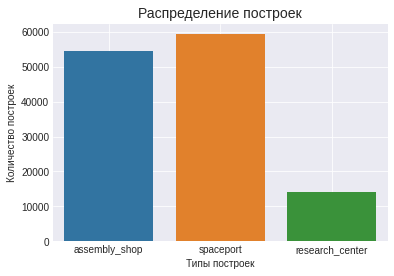

In [21]:
buildings = game_actions['building_type'].value_counts().reset_index()
buildings['%_of_total'] = round((buildings['building_type']/buildings['building_type'].sum()*100), 2)
buildings = buildings.rename(columns = {'index':'building_type', 'building_type':'amount'})
display(buildings)

sns.countplot(game_actions['building_type'])
plt.grid()
plt.title('Распределение построек', fontsize = 14)
plt.xlabel('Типы построек')
plt.ylabel('Количество построек')
plt.show

Почти 89% построек практически поровну поделено между космопортом и сборочным цехом. Исследовательский центр построило в разы меньшее количество пользователей. Пока непонятно, чем вызвано такое отставание в количестве построек. Попробуем взглянуть на строительство в динамике:


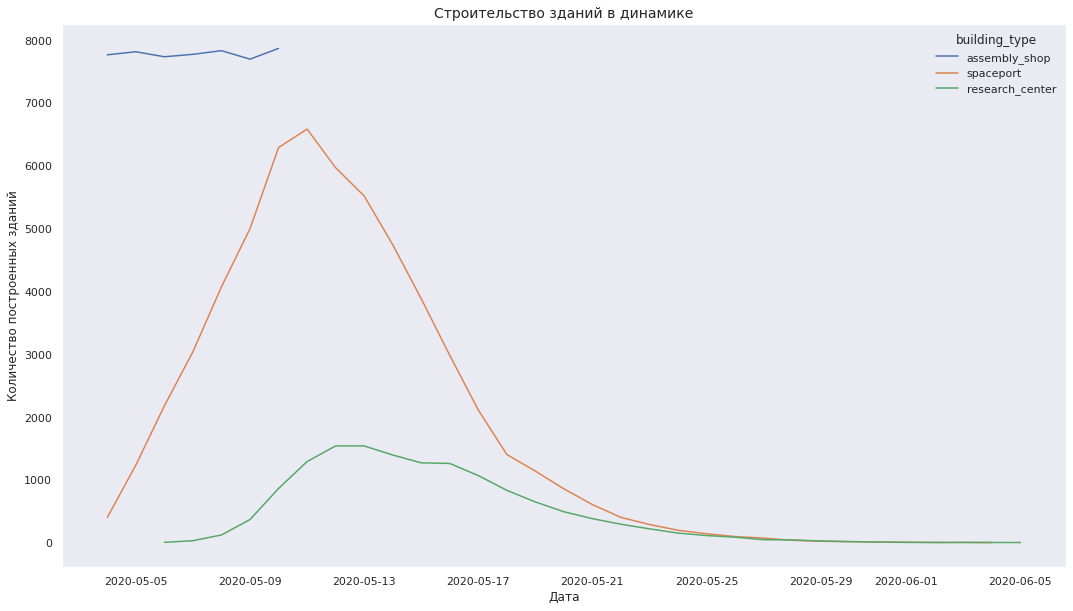

In [22]:
game_actions['event_date'] = game_actions['event_datetime'].dt.date # переводим в формат даты
dynamic_building = game_actions.groupby(['event_date', 'building_type'])['user_id'].count().reset_index()  # группируем
sns.set(rc={'figure.figsize':(18,10)})
sns.lineplot(data=dynamic_building, x='event_date', y='user_id', hue='building_type')

plt.title('Строительство зданий в динамике', fontsize = 14)
plt.ylabel('Количество построенных зданий')
plt.xlabel('Дата')
plt.grid() 
plt.show()

Судя по диаграмме, сборочный цех это начальная постройка, которая нужна лишь на начальном этапе игры. Потом она либо не нужна, либо ее нельзя построить. Космопорт начинают строить практически сразу после сборочного цеха, и примерно спустя восемь дней его строительство выходит на максимум, затем начинается спад. Исследователський центр тоже начинают строить достаточно быстро, на второй-третий день, и их количество выходит на пик примерно в то же время, что и космопорт, затем идет на спад. Примерно через три недели строительство прекращается почти полностью, пользователи либо перешли на второй уровень, либо нашли другую игру, что весьма прискорбно.

Теперь посмотрим на наши источники трафика:

In [23]:
ad_costs['source'].value_counts()

facebook_ads               7
instagram_new_adverts      7
yandex_direct              7
youtube_channel_reklama    7
Name: source, dtype: int64

Всего четыре источника, которые распределены в следующем интервале:

In [24]:
print(f'Минимальная дата события {ad_costs["day"].min()}.')
print(f'Максимальная дата события {ad_costs["day"].max()}.')

Минимальная дата события 2020-05-03 00:00:00.
Максимальная дата события 2020-05-09 00:00:00.


### Выводы

В игре 13576 уникальных пользователей, которые играют в нее месяц. На второй уровень перешло 5817 пользователей, или 42.85 % игроков. Наблюдается дисбаланс в количестве построек - большинство составляют постройки двух типов. 

У нас есть четыре источника привлечения: YouTube, Yandex Direct, Facebook, Instagram.

## Анализ маркетинговых данных

Посмотрим, как же распределяются финансовые потоки в нашей игре.

Для начала посчитаем общий бюджет на маркетинг:

In [25]:
total = ad_costs['cost'].sum()
total = round(total)
print(f'Общая сумма маркетинговых затрат: {total}.')

Общая сумма маркетинговых затрат: 7604.


Получается вполне приличная сумма. 

Теперь узнаем, на какие каналы привлечения мы ее распределяем:

In [26]:
ads = ad_costs.groupby('source').agg({'cost':'sum'}).reset_index().sort_values(by='cost', ascending = False).round(2)
ads['%_of_total'] = round((ads['cost']/ads['cost'].sum()*100), 2)
display(ads)

,source,cost,%_of_total
2,yandex_direct,2233.11,29.37
1,instagram_new_adverts,2161.44,28.43
0,facebook_ads,2140.90,28.16
3,youtube_channel_reklama,1068.12,14.05


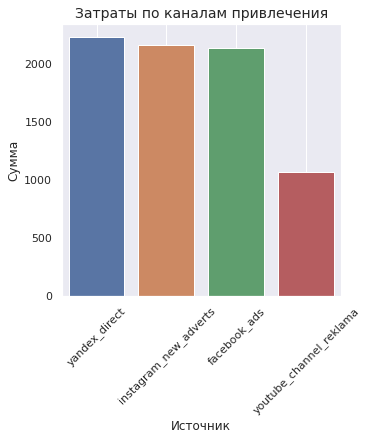

In [27]:
sns.set(rc={'figure.figsize':(5,5)})
sns.barplot(data=ads, x="source", y="cost")
#ad_costs.groupby('source').agg({'cost':'sum'}).sort_values(by='cost', ascending = False).round(2).plot(kind = 'bar', grid = True, figsize = (8, 5))

plt.grid()
plt.ylabel('Сумма')
plt.xlabel('Источник')
plt.title('Затраты по каналам привлечения', fontsize = 14)
plt.xticks(rotation=45)
plt.show()

Получился ряд менее приличных сумм. Мы видим, что меньше всего потребляет канал на YouTube. Рекламные расходы между остальными источниками поделились примерно одинаково.

Теперь посмотрим, сколько пользователей нам принесли эти источники:

In [28]:
ad_sources = user_source['source'].value_counts().reset_index().sort_values(by='source', ascending = False)
ad_sources['%_of_total'] = round((ad_sources['source']/ad_sources['source'].sum()*100), 2)
ad_sources = ad_sources.rename(columns = {'index':'source', 'source':'users'})
display(ad_sources)

,source,users,%_of_total
0,yandex_direct,4817,35.48
1,instagram_new_adverts,3347,24.65
2,facebook_ads,2726,20.08
3,youtube_channel_reklama,2686,19.78


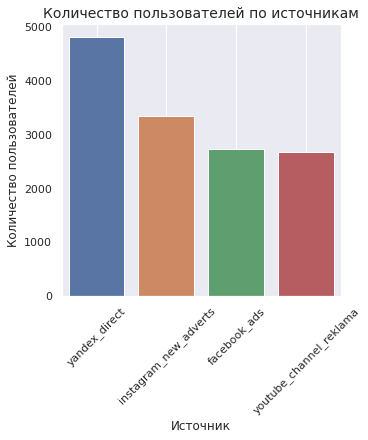

In [29]:
#ad_sources.groupby('source').agg({'users':'sum'}).sort_values(by='users', ascending = False).round(2).plot(kind = 'bar', grid = True, figsize = (8, 5))
sns.barplot(data=ad_sources, x="source", y="users")
sns.set(rc={'figure.figsize':(5,5)})
plt.grid()
plt.ylabel('Количество пользователей')
plt.xlabel('Источник')
plt.title('Количество пользователей по источникам', fontsize = 14)
plt.xticks(rotation=45)
plt.show()

Самый дорогой канал Яндекс Директ привлекает больше всего пользователей. Но самый малобюджетный канал YouTube привлекает почти столько же пользователей, сколько и остальные каналы! За 14% рекламного бюджета мы получаем почти 20% пользователей!

Теперь посмотрим, как быстро мы тратим деньги:

In [30]:
time_costs = ad_costs.pivot_table(index = 'source', columns = 'day', values = 'cost')  # сводная табличка

day,2020-05-03,2020-05-04,2020-05-05,2020-05-06,2020-05-07,2020-05-08,2020-05-09
source,,,,,,,
facebook_ads,935.882786,548.354480,260.185754,177.982200,111.766796,68.009276,38.723350
instagram_new_adverts,943.204717,502.925451,313.970984,173.071145,109.915254,71.578739,46.775400
yandex_direct,969.139394,554.651494,308.232990,180.917099,114.429338,62.961630,42.779505
youtube_channel_reklama,454.224943,259.073224,147.041741,88.506074,55.740645,40.217907,23.314669


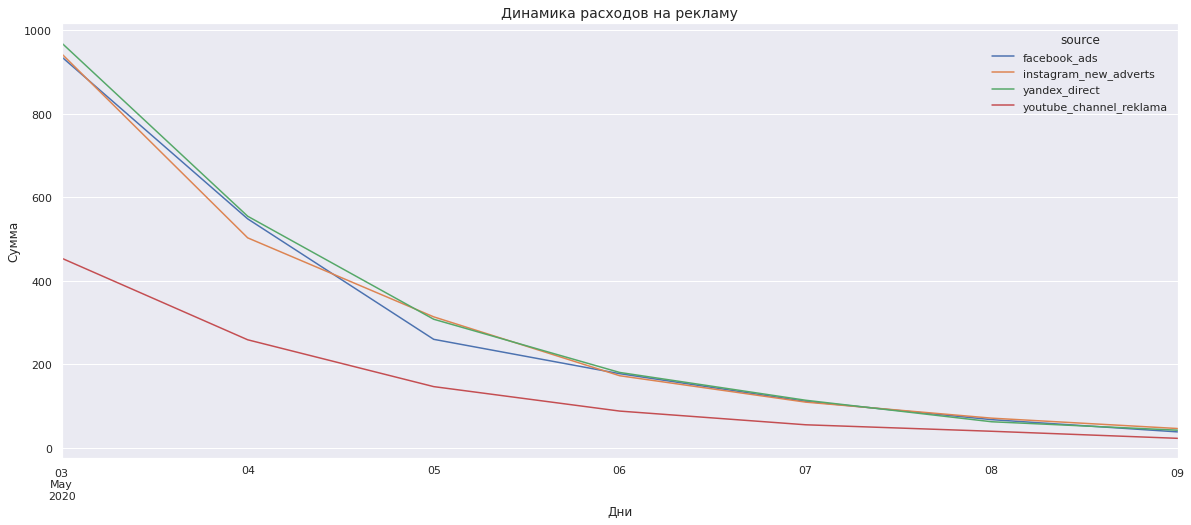

In [31]:
display(time_costs)

time_costs.T.plot(figsize=(20, 8), grid=True)
plt.ylabel('Сумма')
plt.xlabel('Дни')
plt.title('Динамика расходов на рекламу', fontsize = 14)
plt.show()

Увы, рекламные бюджеты не резиновые, и расходы на рекламу падают. 

Теперь было бы неплохо узнать стоимость привлечения пользователей:

In [32]:
cac = ad_costs.groupby('source')['cost'].sum()/user_source['user_id'].nunique()
cac = cac.reset_index().sort_values(by = 'cost', ascending = False)
ads = ads.merge(cac, how = 'left', on = 'source')
ads = ads.rename(columns = {'cost_x':'cost','cost_y':'cac'})
display(ads)

,source,cost,%_of_total,cac
0,yandex_direct,2233.11,29.37,0.164490
1,instagram_new_adverts,2161.44,28.43,0.159210
2,facebook_ads,2140.90,28.16,0.157698
3,youtube_channel_reklama,1068.12,14.05,0.078677


Со значительным отрывом лидирует YouTube - более, чем вдвое ниже остальных каналов. 

### Выводы

Общая сумма маркетинговых затрат на четыре канала привлечения составляет 7604 условных единицы. Самая низкая стоимость привлечения пользователей и лучшая эфективность у самого малобюджетного канала YouTube. 

## Анализ влияния событий на наступление целевого события

Теперь посмотрим, как обстоят дела со временем прохождения игры, как долго наши пользователи добираются до второго уровня.

Для этого мы поступим следующим образом: создадим ряд временных таблиц с их последующим объединением.

Первая таблица со временем первого события в игре:

In [33]:
start_event = game_actions.groupby('user_id')['event_datetime'].min()  # группируем по пользователям, первое событие
start_event = start_event.reset_index()
start_event = start_event.rename(columns ={'event_datetime':'start'})
display(start_event.head(5))

,user_id,start
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-06 01:07:37
1,00151b4f-ba38-44a8-a650-d7cf130a0105,2020-05-06 03:09:12
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,2020-05-05 18:08:52
3,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-05 21:02:05
4,002f508f-67b6-479f-814b-b05f00d4e995,2020-05-05 13:49:58


Вторая таблица со временем последнего события в игре:

In [34]:
end_event = game_actions.groupby('user_id')['event_datetime'].max()  # группируем по пользователям, последнее событие
end_event = end_event.reset_index()
end_event = end_event.rename(columns ={'event_datetime':'end'})
end_event.head(5)

,user_id,end
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-20 11:26:06
1,00151b4f-ba38-44a8-a650-d7cf130a0105,2020-05-18 10:46:52
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,2020-05-14 09:21:27
3,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-12 07:40:47
4,002f508f-67b6-479f-814b-b05f00d4e995,2020-05-22 02:46:45


Получили таблицу со временем первого и последнего события:

In [35]:
delta_events = start_event.merge(end_event, how = 'left', on = 'user_id')
delta_events.head(5)

,user_id,start,end
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-06 01:07:37,2020-05-20 11:26:06
1,00151b4f-ba38-44a8-a650-d7cf130a0105,2020-05-06 03:09:12,2020-05-18 10:46:52
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,2020-05-05 18:08:52,2020-05-14 09:21:27
3,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-05 21:02:05,2020-05-12 07:40:47
4,002f508f-67b6-479f-814b-b05f00d4e995,2020-05-05 13:49:58,2020-05-22 02:46:45


Добавляем столбец с разнице во времени, получаем точную продолжительность игрового процесса:

In [36]:
delta_events['delta'] = delta_events['end'] - delta_events['start']

И для удобства расчетов добавляем столбец с округлением по дням игры:

In [37]:
delta_events['delta_days'] = delta_events['delta'].dt.days

Проверяем результат. Все присутствует.

In [38]:
delta_events.head(5)

,user_id,start,end,delta,delta_days
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-06 01:07:37,2020-05-20 11:26:06,14 days 10:18:29,14
1,00151b4f-ba38-44a8-a650-d7cf130a0105,2020-05-06 03:09:12,2020-05-18 10:46:52,12 days 07:37:40,12
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,2020-05-05 18:08:52,2020-05-14 09:21:27,8 days 15:12:35,8
3,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-05 21:02:05,2020-05-12 07:40:47,6 days 10:38:42,6
4,002f508f-67b6-479f-814b-b05f00d4e995,2020-05-05 13:49:58,2020-05-22 02:46:45,16 days 12:56:47,16


Теперь добавляем все, что у нас получилось к таблице `game_actions`:

In [39]:
events_time = game_actions.merge(delta_events, how = 'left', on = 'user_id')

In [40]:
events_time.head(5)

,event_datetime,event,building_type,user_id,project_type,event_date,start,end,delta,delta_days
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,unknown,2020-05-04,2020-05-04 00:00:01,2020-05-10 20:27:01,6 days 20:27:00,6
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,unknown,2020-05-04,2020-05-04 00:00:03,2020-05-15 05:29:13,11 days 05:29:10,11
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,unknown,2020-05-04,2020-05-04 00:00:16,2020-05-16 11:51:58,12 days 11:51:42,12
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,unknown,2020-05-04,2020-05-04 00:00:16,2020-05-12 04:29:54,8 days 04:29:38,8
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,unknown,2020-05-04,2020-05-04 00:00:35,2020-05-11 14:18:05,7 days 14:17:30,7


In [41]:
events_time.to_csv(r'С:\events_time.csv')

In [42]:
print(f'Среднее время в игре {events_time["delta_days"].mean().round(2)} дней')

Среднее время в игре 11.24 дней


Получилось прекрасно, вся информация присутствует.

Теперь начинаем разбираться в наших победителях. Сначала посмотрим на тех, кто смог осилить постройку орбитальной станции:

In [43]:
projectants = events_time.query('project_type=="satellite_orbital_assembly"')
print(f"Количество пользователей, перешедших на второй уровень через постройку проекта: {projectants['user_id'].count()}.")

Количество пользователей, перешедших на второй уровень через постройку проекта: 1866.


1866 пользователей, все сходится.

Теперь посмотрим, кто смог пройти на второй уровень, одержав победу над врагом:

In [44]:
ids = projectants['user_id'].tolist()  # сделал список айди игроков, которые построили проект

In [45]:
warriors = events_time.query('event=="finished_stage_1" and user_id not in @ids')
print(f"Количество пользователей, перешедших на второй уровень через победу над врагом: {warriors['user_id'].count()}.")


Количество пользователей, перешедших на второй уровень через победу над врагом: 3951.


И у нас есть 3951 пользователь, который вырвал победу в честном бою.

Теперь посмотрим, как строили успешные игроки. Начнем с главных строителей - тех, кто осилил орбитальный проект:

In [46]:
projectants_buildings = game_actions.query('user_id in @ids')  # фильтруем

,building_type,amount,%_of_total
0,spaceport,10788,45.71
1,assembly_shop,9116,38.63
2,research_center,3697,15.66


<function matplotlib.pyplot.show(close=None, block=None)>

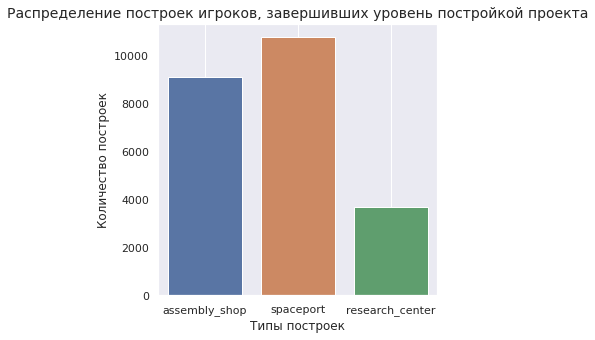

In [47]:
project_buildings = projectants_buildings['building_type'].value_counts().reset_index()
project_buildings['%_of_total'] = round((project_buildings['building_type']/project_buildings['building_type'].sum()*100), 2)
project_buildings = project_buildings.rename(columns = {'index':'building_type', 'building_type':'amount'})
display(project_buildings)

sns.countplot(projectants_buildings['building_type'])
plt.grid()
plt.title('Распределение построек игроков, завершивших уровень постройкой проекта', fontsize = 14)
plt.xlabel('Типы построек')
plt.ylabel('Количество построек')
plt.show

Преобладают начальные постройки, 15% построили исследовательский центр.

Теперь посмотрим, как действовали пользователи, решившие идти тропой войны:

In [48]:
war_ids = warriors['user_id'].tolist()  # сделал список айди игроков, которые победили врага

In [49]:
warriors_buildings = game_actions.query('user_id in @war_ids')  # фильтруем

,building_type,amount,%_of_total
0,spaceport,17132,46.07
1,assembly_shop,16298,43.83
2,research_center,3755,10.10


<function matplotlib.pyplot.show(close=None, block=None)>

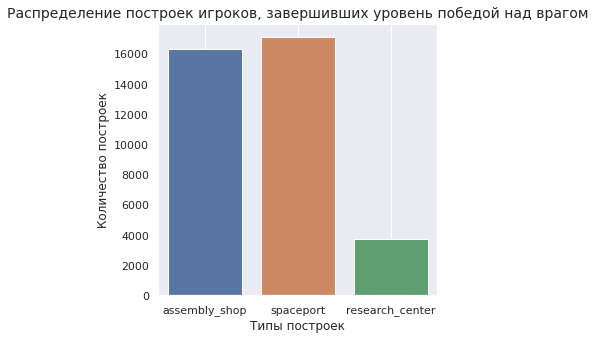

In [50]:
war_buildings = warriors_buildings['building_type'].value_counts().reset_index()
war_buildings['%_of_total'] = round((war_buildings['building_type']/war_buildings['building_type'].sum()*100), 2)
war_buildings = war_buildings.rename(columns = {'index':'building_type', 'building_type':'amount'})
display(war_buildings)

sns.countplot(warriors_buildings['building_type'])
plt.grid()
plt.title('Распределение построек игроков, завершивших уровень победой над врагом', fontsize = 14)
plt.xlabel('Типы построек')
plt.ylabel('Количество построек')
plt.show

Мы видим, что игроки, которые любят воевать, реже строили исследовательский центр, но чаще строили сборочные цеха - для войны нужно строить много юнитов))

Среднее количество дней в игре для игроков, завершивших уровень постройкой проекта: 13.0
Кол-во пользователей: 1866.
Процент пользователей, перешедших на второй уровень через строительство проекта: 13.74 %.


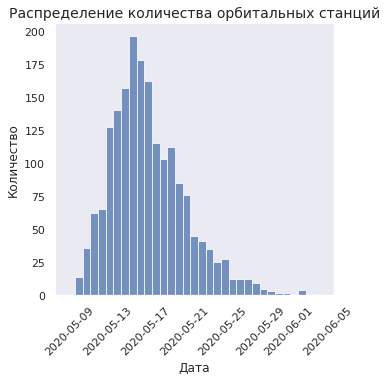

In [51]:
print(f"Среднее количество дней в игре для игроков, завершивших уровень постройкой проекта: {projectants['delta_days'].mean().round()}")
print(f'Кол-во пользователей: {projectants["user_id"].count()}.')
projectants_winners = projectants["user_id"].count()/game_actions["user_id"].nunique()*100
print(f'Процент пользователей, перешедших на второй уровень через строительство проекта: {round(projectants_winners, 2)} %.')



sns.histplot(data=projectants, x="event_datetime")
plt.grid()
plt.ylabel('Количество')
plt.xlabel('Дата')
plt.title('Распределение количества орбитальных станций', fontsize = 14)
plt.xticks(rotation = 45)
plt.show()

1866 человек в среднем тратят 13 дней на постройку орбитальной станции, что составляет 13,7% от общего числа пользователей. Распределение событий смещено вправо. Самые активные пользователи успевают построить станцию за 4 дня. График достигает пика к 15 мая.

Теперь посмотрим, как обстоят дела у тех, кто любит PvP:

Среднее количество дней в игре для игроков, завершивших уровень победой над врагом: 11.0
Кол-во пользователей: 3951.
Процент пользователей, перешедших на второй уровень через победу над врагом: 29.1 %.


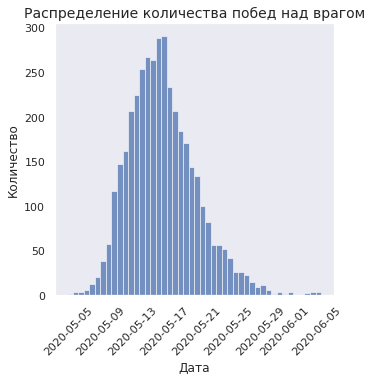

In [52]:
print(f"Среднее количество дней в игре для игроков, завершивших уровень победой над врагом: {warriors['delta_days'].mean().round()}")
print(f'Кол-во пользователей: {warriors["user_id"].count()}.')
warriors_winners = warriors["user_id"].count()/game_actions["user_id"].nunique()*100
print(f'Процент пользователей, перешедших на второй уровень через победу над врагом: {round(warriors_winners, 2)} %.')

sns.histplot(data=warriors, x="event_datetime")
sns.set(rc={'figure.figsize':(5,5)})
plt.grid()
plt.ylabel('Количество')
plt.xlabel('Дата')
plt.title('Распределение количества побед над врагом', fontsize = 14)
plt.xticks(rotation = 45)
plt.show()

Игра поощряет активный стиль. 3951 человек в среднем тратят 11 дней на одержание победы над первым врагом, что составляет 29,1 % от общего количества. Распределение уже ближе к нормальному. 

Посмотрим на процентное соотношение победителей:

In [53]:
winners = game_actions.query('event == "finished_stage_1"')
winners = winners['user_id'].count()
print(f"Процент победивших врага среди перешедших на второй уровень: {(projectants['user_id'].count()/winners*100).round(2)} %")
print(f"Процент завершивших проект среди перешедших на второй уровень: {(warriors['user_id'].count()/winners*100).round(2)} %")

Процент победивших врага среди перешедших на второй уровень: 32.08 %
Процент завершивших проект среди перешедших на второй уровень: 67.92 %


Количество агрессивных игроков в два раза больше.

Теперь посмотрим, как себя ведут пользователи, которые по каким-то причинам не смогли завершить уровень. 

Для начала оценим их среднее время в игре:

In [54]:
remainers = events_time.query('user_id not in @war_ids')
remainers = remainers.query('user_id not in @ids')

Среднее количество дней в игре для игроков, не завершивших уровень: 11.0
Количество пользователей: 7759.
Процент пользователей, не перешедших на второй уровень: 57.15 %.


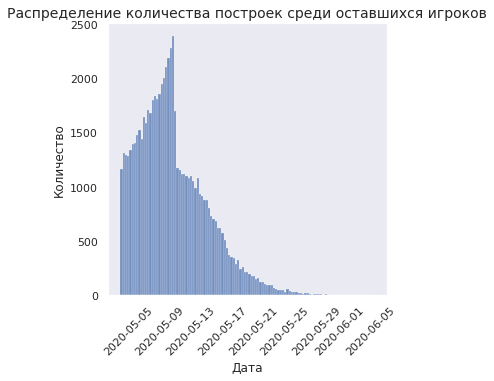

In [55]:
print(f"Среднее количество дней в игре для игроков, не завершивших уровень: {remainers['delta_days'].mean().round()}")
print(f'Количество пользователей: {remainers["user_id"].nunique()}.')
remains = remainers["user_id"].nunique()/events_time["user_id"].nunique()*100
print(f'Процент пользователей, не перешедших на второй уровень: {round(remains, 2)} %.')


sns.histplot(data=remainers, x="event_datetime")

plt.ylabel('Количество')
plt.xlabel('Дата')
plt.title('Распределение количества построек среди оставшихся игроков', fontsize = 14)
plt.xticks(rotation = 45)
plt.grid()
plt.show()

Время максимальной активности пользователей, не прошедших первый уровень примерно четыре дня. Затем они строят намного реже, судя по всему, интерес к игре пропадает.

,building_type,amount,%_of_total
0,spaceport,31405,46.75
1,assembly_shop,29080,43.29
2,research_center,6685,9.95


<function matplotlib.pyplot.show(close=None, block=None)>

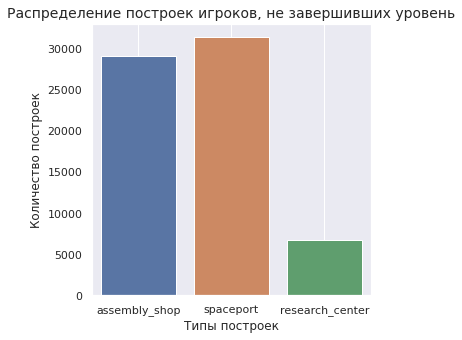

In [56]:
rems = remainers['building_type'].value_counts().reset_index()
rems['%_of_total'] = round((rems['building_type']/rems['building_type'].sum()*100), 2)
rems = rems.rename(columns = {'index':'building_type', 'building_type':'amount'})
display(rems)

sns.countplot(remainers['building_type'])
plt.grid()
plt.title('Распределение построек игроков, не завершивших уровень', fontsize = 14)
plt.xlabel('Типы построек')
plt.ylabel('Количество построек')
plt.show

Паттер распределения построек по типам ближе к агрессивным игрокам, но что-то помешало пользователям победить врага.

### Выводы

Игроки, выбравшие агрессивный стиль игры, в среднем на два дня быстрее переходят на второй уровень, их общее количество составляет больше трети от всех пользователей. Их среднее время игры близко к среднему для всех игроков. Игроки, которые не перешли на второй уровень, похожи по стилю игры на агрессивных игроков.

## Проверка статистических гипотез

Теперь нам нужно проверить статистическую гипотезу, выдвинутую заказчиком, об одинаковом времени прохождения игры путем реализации проекта и победой над врагом. В принципе, мы и так уже знаем, что это не так, но техзадание есть техзадание.

Берем на рассмотрение следующие гипотезы:

Н0 - Время прохождения уровня между пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком, равны.

Н1 - Время прохождения уровня между пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком, не равны.

In [57]:
alpha = 0.05 # задаем уровень статистической значимости

results = st.ttest_ind(projectants['delta_days'], warriors['delta_days'])
print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу, различие между пользователями есть")
else:
    print("Не получилось отвергнуть нулевую гипотезу, различия между пользователями нет")

p-значение:  1.8882835392369192e-97
Отвергаем нулевую гипотезу, различие между пользователями есть


Теперь мы точно уверены, что 13 больше 11! Постройка спутниковой станции отнимает значительно больше времени.

Теперь проверяем нашу гипотезу о том, что из разных источников приходят люди с разными навыками игры в компьютерные игры, и их время прохождения уровня может различаться. Чем больше они будут тратить времени, тем больше рекламы они посмотрят.

Выдвигаем гипотезы:

Н0 = Пользователи из различных источников тратят равное время на прохождение уровня.

Н1 = Пользователи из различных источников тратят неравное время на прохождение уровня.

In [58]:
source_dates = events_time.merge(user_source, how = 'left', on = 'user_id')  # объединяем таблицы, чтобы видеь время прхождения

Выделяем таблицы по источникам привлечения:

In [59]:
yandex = source_dates.query('source=="yandex_direct"')
instagram = source_dates.query('source=="instagram_new_adverts"')
facebook = source_dates.query('source=="facebook_ads"')
youtube = source_dates.query('source=="youtube_channel_reklama"')

Напишем небольшую фнукцию для удобства, так как у нас 6 пар сравнений:

In [60]:
def sources_comparison(df1, df2):  # подставляем таблицы
    results = st.ttest_ind(df1['delta_days'], df2['delta_days'])
    bonferroni_alpha = alpha / 6 
    print('p-значение: ', results.pvalue)

    if (results.pvalue < bonferroni_alpha):
        print(f"Отвергаем нулевую гипотезу, различие во времени прохождения уровня между пользователями источников есть")
    else:
        print(f"Не получилось отвергнуть нулевую гипотезу, различия во времени прохождения уровня между пользователями источников нет")
    

In [61]:
sources_comparison(yandex, youtube)

p-значение:  0.5805443260669059
Не получилось отвергнуть нулевую гипотезу, различия во времени прохождения уровня между пользователями источников нет


In [62]:
print(f'Среднее количество дней прохождения {yandex["delta_days"].mean().round(2)}')
print(f'Среднее количество дней прохождения {youtube["delta_days"].mean().round(2)}')

Среднее количество дней прохождения 11.18
Среднее количество дней прохождения 11.2


In [63]:
sources_comparison(yandex, instagram)

p-значение:  4.019047485269057e-08
Отвергаем нулевую гипотезу, различие во времени прохождения уровня между пользователями источников есть


In [64]:
print(f'Среднее количество дней прохождения {yandex["delta_days"].mean().round(2)}')
print(f'Среднее количество дней прохождения {instagram["delta_days"].mean().round(2)}')

Среднее количество дней прохождения 11.18
Среднее количество дней прохождения 11.34


In [65]:
sources_comparison(yandex, facebook)

p-значение:  0.006424997020913236
Отвергаем нулевую гипотезу, различие во времени прохождения уровня между пользователями источников есть


In [66]:
print(f'Среднее количество дней прохождения {yandex["delta_days"].mean().round(2)}')
print(f'Среднее количество дней прохождения {facebook["delta_days"].mean().round(2)}')

Среднее количество дней прохождения 11.18
Среднее количество дней прохождения 11.26


In [67]:
sources_comparison(instagram, facebook)

p-значение:  0.02274386140328288
Не получилось отвергнуть нулевую гипотезу, различия во времени прохождения уровня между пользователями источников нет


In [68]:
print(f'Среднее количество дней прохождения {instagram["delta_days"].mean().round(2)}')
print(f'Среднее количество дней прохождения {facebook["delta_days"].mean().round(2)}')

Среднее количество дней прохождения 11.34
Среднее количество дней прохождения 11.26


In [69]:
sources_comparison(instagram, youtube)

p-значение:  2.0158229560877532e-05
Отвергаем нулевую гипотезу, различие во времени прохождения уровня между пользователями источников есть


In [70]:
print(f'Среднее количество дней прохождения {instagram["delta_days"].mean().round(2)}')
print(f'Среднее количество дней прохождения {youtube["delta_days"].mean().round(2)}')

Среднее количество дней прохождения 11.34
Среднее количество дней прохождения 11.2


In [71]:
sources_comparison(facebook, youtube)

p-значение:  0.05550751145944763
Не получилось отвергнуть нулевую гипотезу, различия во времени прохождения уровня между пользователями источников нет


In [72]:
print(f'Среднее количество дней прохождения {facebook["delta_days"].mean().round(2)}')
print(f'Среднее количество дней прохождения {youtube["delta_days"].mean().round(2)}')

Среднее количество дней прохождения 11.26
Среднее количество дней прохождения 11.2


И вот тут начинается самое интересное. Нет статистически значимой разницы для пар каналов Yandex - YouTube / Instagram - Facebook/Facebook - YouTube. Все остальные пары каналов показывают, что статистически значимая разница между ними есть.

Посмотрим на среднее время прохождения пользователями из различных каналов привлечения:

In [73]:
play_days = source_dates.groupby('source').agg({'delta_days':'mean'})

In [74]:
play_days.sort_values(by = 'delta_days', ascending = False).round(2)

,delta_days
source,
instagram_new_adverts,11.34
facebook_ads,11.26
youtube_channel_reklama,11.20
yandex_direct,11.18


В целом разница не критичная, в пределах десятых долей, но она есть. Пользователи Яндекса проходят игру быстрее всех. Пользователи Instagram держатся позади всех.

### Выводы

Мы убедились, что время прохождения уровня между пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком, различается. Также мы обнаружили статистически значимую разницу во времени прохождения на второй уровень среди пользователей, привлеченных через разные каналы.

## Разработка модели монетизации

Мы приступаем к самой интересной части - нужно посмотреть, как мы можем заработать на нашей игре. Мы знаем, что пока планируется показывать рекламу перед постройкой каждого здания. Для начала сделаем технический датафрейм - уберем всех игроков, которые уже завершили проект - мы не знаем, как и что они строили, эти данные нужно уточнять у разработчиков:

И еще раз освежим в памяти наши расходы на привлечение пользователей с разбитием по источникам:

In [76]:
print(f'Общая сумма маркетинговых затрат: {total}.')

Общая сумма маркетинговых затрат: 7604.


In [77]:
ad_sources

,source,users,%_of_total
0,yandex_direct,4817,35.48
1,instagram_new_adverts,3347,24.65
2,facebook_ads,2726,20.08
3,youtube_channel_reklama,2686,19.78


По условиям нам известно, что за каждый показ рекламы мы получаем 7 центов, т.е. 0.07 условной единицы. Посмотрим, сколько нам удастся заработать, если мы будем показывать рекламу перед постройкой каждого здания:

In [78]:
ad = 0.07  # сумма с одного объявления

In [79]:
max_gain = (events_time['building_type'].count())*ad
print(f'Максимальная сумма выручки от показа рекламы перед всеми событиями: {max_gain}.')

Максимальная сумма выручки от показа рекламы перед всеми событиями: 8956.92.


Что ж, нам удастся отбить расходы на привлечение и даже немного заработать. 

Напомним распределение типов построек:

In [80]:
buildings

,building_type,amount,%_of_total
0,spaceport,59325,46.36
1,assembly_shop,54494,42.59
2,research_center,14137,11.05


87% приходится на первые два типа построек, до третьего доходят всего 11%. Вероятно, постройка исследовательского центра более востребована при выборе тактики строительства орбитальной станции. 

Посмотрим, сколько зданий в среднем приходится на пользователя, если мы берем в расчет все постройки:

In [81]:
buildings_per_users  = (events_time['building_type'].count()/events_time['user_id'].nunique()).round(2)
print(f'Среднее количество всех типов зданий на пользователя: {buildings_per_users}')

Среднее количество всех типов зданий на пользователя: 9.43


Если отбросить исследовательский центр, то количество построек на пользователя падает:

In [82]:
events_time_2 = events_time.query('building_type!="research_center"')
buildings_per_users_2 = (events_time_2['building_type'].count()/events_time_2['user_id'].nunique()).round(2)
print(f'Среднее количество самых распространенных типов зданий на пользователя: {buildings_per_users_2}')

Среднее количество самых распространенных типов зданий на пользователя: 8.38


Посмотрим, какое минимальное количество рекламных объявлений нам нужно показать, чтобы выйти в ноль:

In [83]:
min_ads = total/ad
print(f'Необходимое для окупаемости количество показов рекламных объявлений: {round(min_ads, 2)}.')

Необходимое для окупаемости количество показов рекламных объявлений: 108628.57.


Получается больше 100 000 объявлений. 

Рассчитаем, с какой частотой надо их показать для всех построек и для первых двух типов, самых популярных в игре:

In [84]:
all_buildings = buildings['amount'].sum()
print(f'Необходимая частота показа рекламы для выхода в ноль каждую {(all_buildings/round(min_ads, 2)).round(2)} постройку для всех построек.')

Необходимая частота показа рекламы для выхода в ноль каждую 1.18 постройку для всех построек.


In [85]:
pop_buildings = buildings.query('building_type=="spaceport" or building_type=="assembly_shop"')['amount'].sum()
print(f'Необходимая частота показа рекламы для выхода в ноль каждую {(pop_buildings/round(min_ads, 2)).round(2)} постройку для самых популярных построек.')

Необходимая частота показа рекламы для выхода в ноль каждую 1.05 постройку для самых популярных построек.


Увы, пока получается так, что нам необходимо показывать рекламу при строительстве каждого здания, иначе выйти на окупаемость будет очень тяжело. Но вряд ли пользователи будут довольны, если они будут видеть рекламу каждый раз, на пользователя, как мы помним, придется минимум восемь показов рекламы. 

Даже если мы будем показывать рекламу на каждой второй постройке, что тоже много, мы провалимся значительно ниже уровня окупаемости:

In [86]:
moderate_gain = (buildings.query('building_type!="unknown"')['amount'].sum()/2)*0.07
print(f'Предполагаемая сумма выручки от показа рекламы при каждом втором строительстве: {moderate_gain}.')

Предполагаемая сумма выручки от показа рекламы при каждом втором строительстве: 4478.46.


Если мы обратимся к нашим источникам привлечения, то мы увидим, что отчасти проблема кроется в высокой стоимости привлечения: только один источник дает нам стоимость привлечения, близкую к заработку на рекламе. Все остальные источники более, чем в два раза дороже.

In [87]:
display(ads)

,source,cost,%_of_total,cac
0,yandex_direct,2233.11,29.37,0.164490
1,instagram_new_adverts,2161.44,28.43,0.159210
2,facebook_ads,2140.90,28.16,0.157698
3,youtube_channel_reklama,1068.12,14.05,0.078677


### Выводы

При текущей стоимости показа рекламы и нашем заработке с ее просмотра требуется показывать рекламу при постройке каждого здания, чтобы выйти на окупаемость. Скорее всего, это негативно скажется на оттоке пользователей, потому что реклама будет показываться очень часто, с учетом того, что большинство пользователей и так останавливается на постройке зданий первых двух типов.

## Общий вывод

Итак, проведя исследование, мы пришли к следующим выводам:

* у нас есть 13576 уникальных пользователей
* активность пользователей в игре сохраняется на протяжении месяца 
* на второй уровень перешло менее половины игроков, а именно 5817 пользователей, или 42.85 %
* наблюдается дисбаланс в количестве построек - большинство составляют постройки первых двух типов судя по всему, геймплей не требует строительства большого колчиества исследовательских центров
* общая сумма маркетинговых затрат на четыре канала привлечения составляет 7604 условных единицы 
* самую низкую стоимость привлечения пользователей и наилучшую эффективность показывает канал YouTube: на 14% маркетингового бюджета приходится 20% привлеченных пользователей
* игроки, выбирающие агрессивный геймплей проходят на второй уровень быстрее, чем те, кто строит орбитальную станцию: 11 дней против 13 в среднем
* 13,74% игроков проходят уровень через постройку проекта, 29,1% через победу над первым врагом
* для пар источников Yandex - YouTube / Instagram - Facebook /Facebook - YouTube присутствует статистически значимая разница во времени прохождения уровня игроками.


Рекомендации и комментарии по игровому процессу:
* необходима доработка таблицы в плане данных о постройках игроков, перешедших на второй уровень - эта информация теряется
* значительно смещен количественный баланс в сторону двух первых типов построек
* игра откровенно поощряет агрессивный геймплей - необходима корректировка баланса

Комментарии по монетизации:
* при существующих каналах привлечения пользователей и стоимости привлечения выход на окупаемость возможен только при показе рекламы при строительстве каждого здания
* стоимость привлечения игроков для всех каналов привлечения, кроме YouTube - более, чем вдвое выше, чем сумма от показа рекламы. 

Предложения по модели монетизации:
* увеличить инвестиции в канал привлечения YouTube: стоимость привлечения полльзователей самая низкая, а привлечение пользователей такое же, как у более, чем вдвое дорогих каналов.
* стоит рассмотреть отказ от каналов Facebook/Instagram - они приносят меньше пользователей, чем Yandex, а стоят вдвое дороже YouTube, который приносит почти такое же количество пользователей.
* показывать рекламу при каждом событии нельзя - это отпугнет пользователей, так как им придется в среднем просмотреть рекламу 8 раз
* нужно пересмотреть баланс для того, чтобы люди больше строили  - в частности, исследовательский центр, тогда количество построек увеличится и можно будет показывать рекламу реже
* стоит рассмотреть альтернативные механизмы монетизации - дропбоксы, премиум-аккаунты, подписку, внутриигровой магазин с бустерами, скинами и т.д.

## Презентация

Основные тезисы и результаты исследования также оформлены в виде презентации, которую можно скачать по ссылке ниже.

[Презентация](https://drive.google.com/file/d/1VDpPV8Imt_vGBVEMjQ1gkDKlw_4nt2t4/view?usp=sharing)
    